In [1]:
import rescomp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
help(rescomp)
help(rescomp.esn)

Help on package rescomp:

NAME
    rescomp - # __init__.py

PACKAGE CONTENTS
    _version
    esn
    locality_measures
    measures
    simulations
    utilities

VERSION
    0.2.1

FILE
    c:\users\dennis\documents\github\rescomp\rescomp\__init__.py


Help on module rescomp.esn in rescomp:

NAME
    rescomp.esn - Implements the Echo State Network (ESN) used in Reservoir Computing

CLASSES
    _ESNCore(rescomp.utilities._ESNLogging)
        ESN
            ESNWrapper
                ESNHybrid
    rescomp.utilities._ESNLogging(builtins.object)
        ESNGenLoc
    
    class ESN(_ESNCore)
     |  Implements basic RC functionality
     |  
     |  This is to be written such that one can easily implement both "normal" RC as
     |  well as local RC, or other generalizations, by using this class as a
     |  building block to be called with the right training and prediction data
     |  
     |  Method resolution order:
     |      ESN
     |      _ESNCore
     |      rescomp.utilities.

In [16]:
esn_normal = rescomp.esn.ESNWrapper()
esn_hybrid = rescomp.esn.ESNHybrid()

In [17]:
simulation_time_steps = 8000
dt = 2e-2

starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=dt, time_steps=simulation_time_steps,
    starting_point=starting_point)

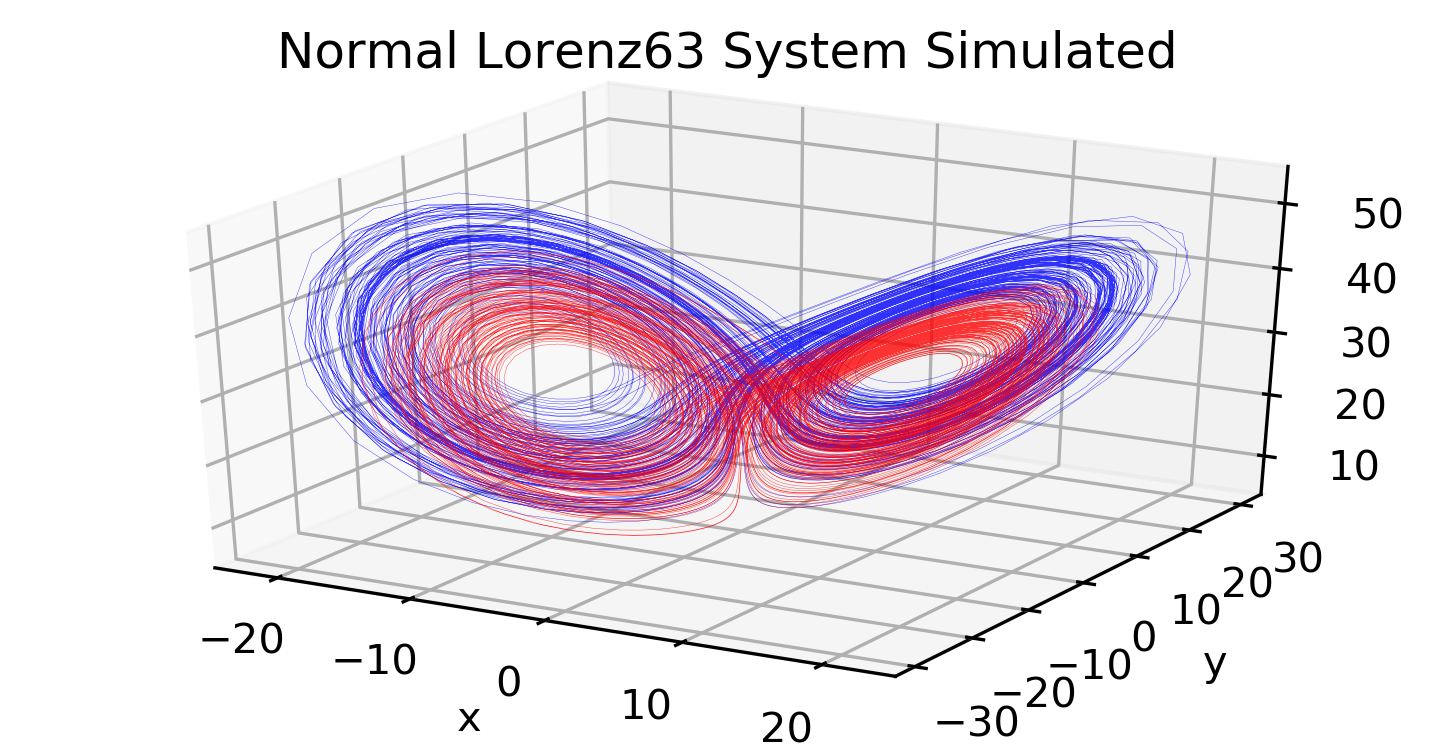

[[-14.03020521 -20.88693127  25.53545   ]
 [-15.65674521 -22.16606473  30.18342593]
 [-17.05513878 -21.98623114  35.36707129]
 [-17.92278342 -20.04083359  40.36261543]
 [-18.00366456 -16.48347616  44.27298178]] [[-14.03020521 -20.88693127  25.53545   ]
 [-15.25797688 -20.51030618  30.15606334]
 [-16.06372202 -18.7186594   34.62178262]
 [-16.27027628 -15.60166621  38.27016227]
 [-15.7840892  -11.61783523  40.55701638]]
(8000, 3) (8000, 3)


In [40]:
#Create artificially "wrong" model
eps1 = 0.2
eps2 = 0.2
eps3 = 0.2
model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))

# model_pred = lambda x: x + model(x)*dt

model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

# test it:
x = np.zeros((simulation_time_steps, 3))

x[0] = starting_point
for i in range(1, simulation_time_steps):
    x_i = x[i-1]
    x[i] = model_pred(x_i)
    
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2],
        alpha=0.8, color='blue', linewidth = 0.1)
ax.plot(sim_data[:, 0], sim_data[:, 1], sim_data[:, 2],
        alpha=0.8, color='red', linewidth = 0.1)

# dif = sim_data - x
# ax.plot(dif[:, 0], dif[:, 1], dif[:, 2],
#         alpha=0.8, color='red', linewidth = 0.1)

ax.set_title("Normal Lorenz63 System Simulated")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

print(x[:5], sim_data[:5])

print(x.shape, sim_data.shape)

In [41]:
np.random.seed(1)

# normal model
esn_normal.create_network()

# hybrid model 
esn_hybrid.create_network()
esn_hybrid.set_model(model_pred)

train_sync_steps = 400
train_steps = 4000
pred_steps = 500  

In [42]:
y_pred_normal, y_test_normal = esn_normal.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps)

y_pred_hybrid, y_test_hybrid = esn_hybrid.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps)

print(y_test_normal == y_test_hybrid)

r_gen shape:  (3999, 500)
u_train shape:  (3999, 3)
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


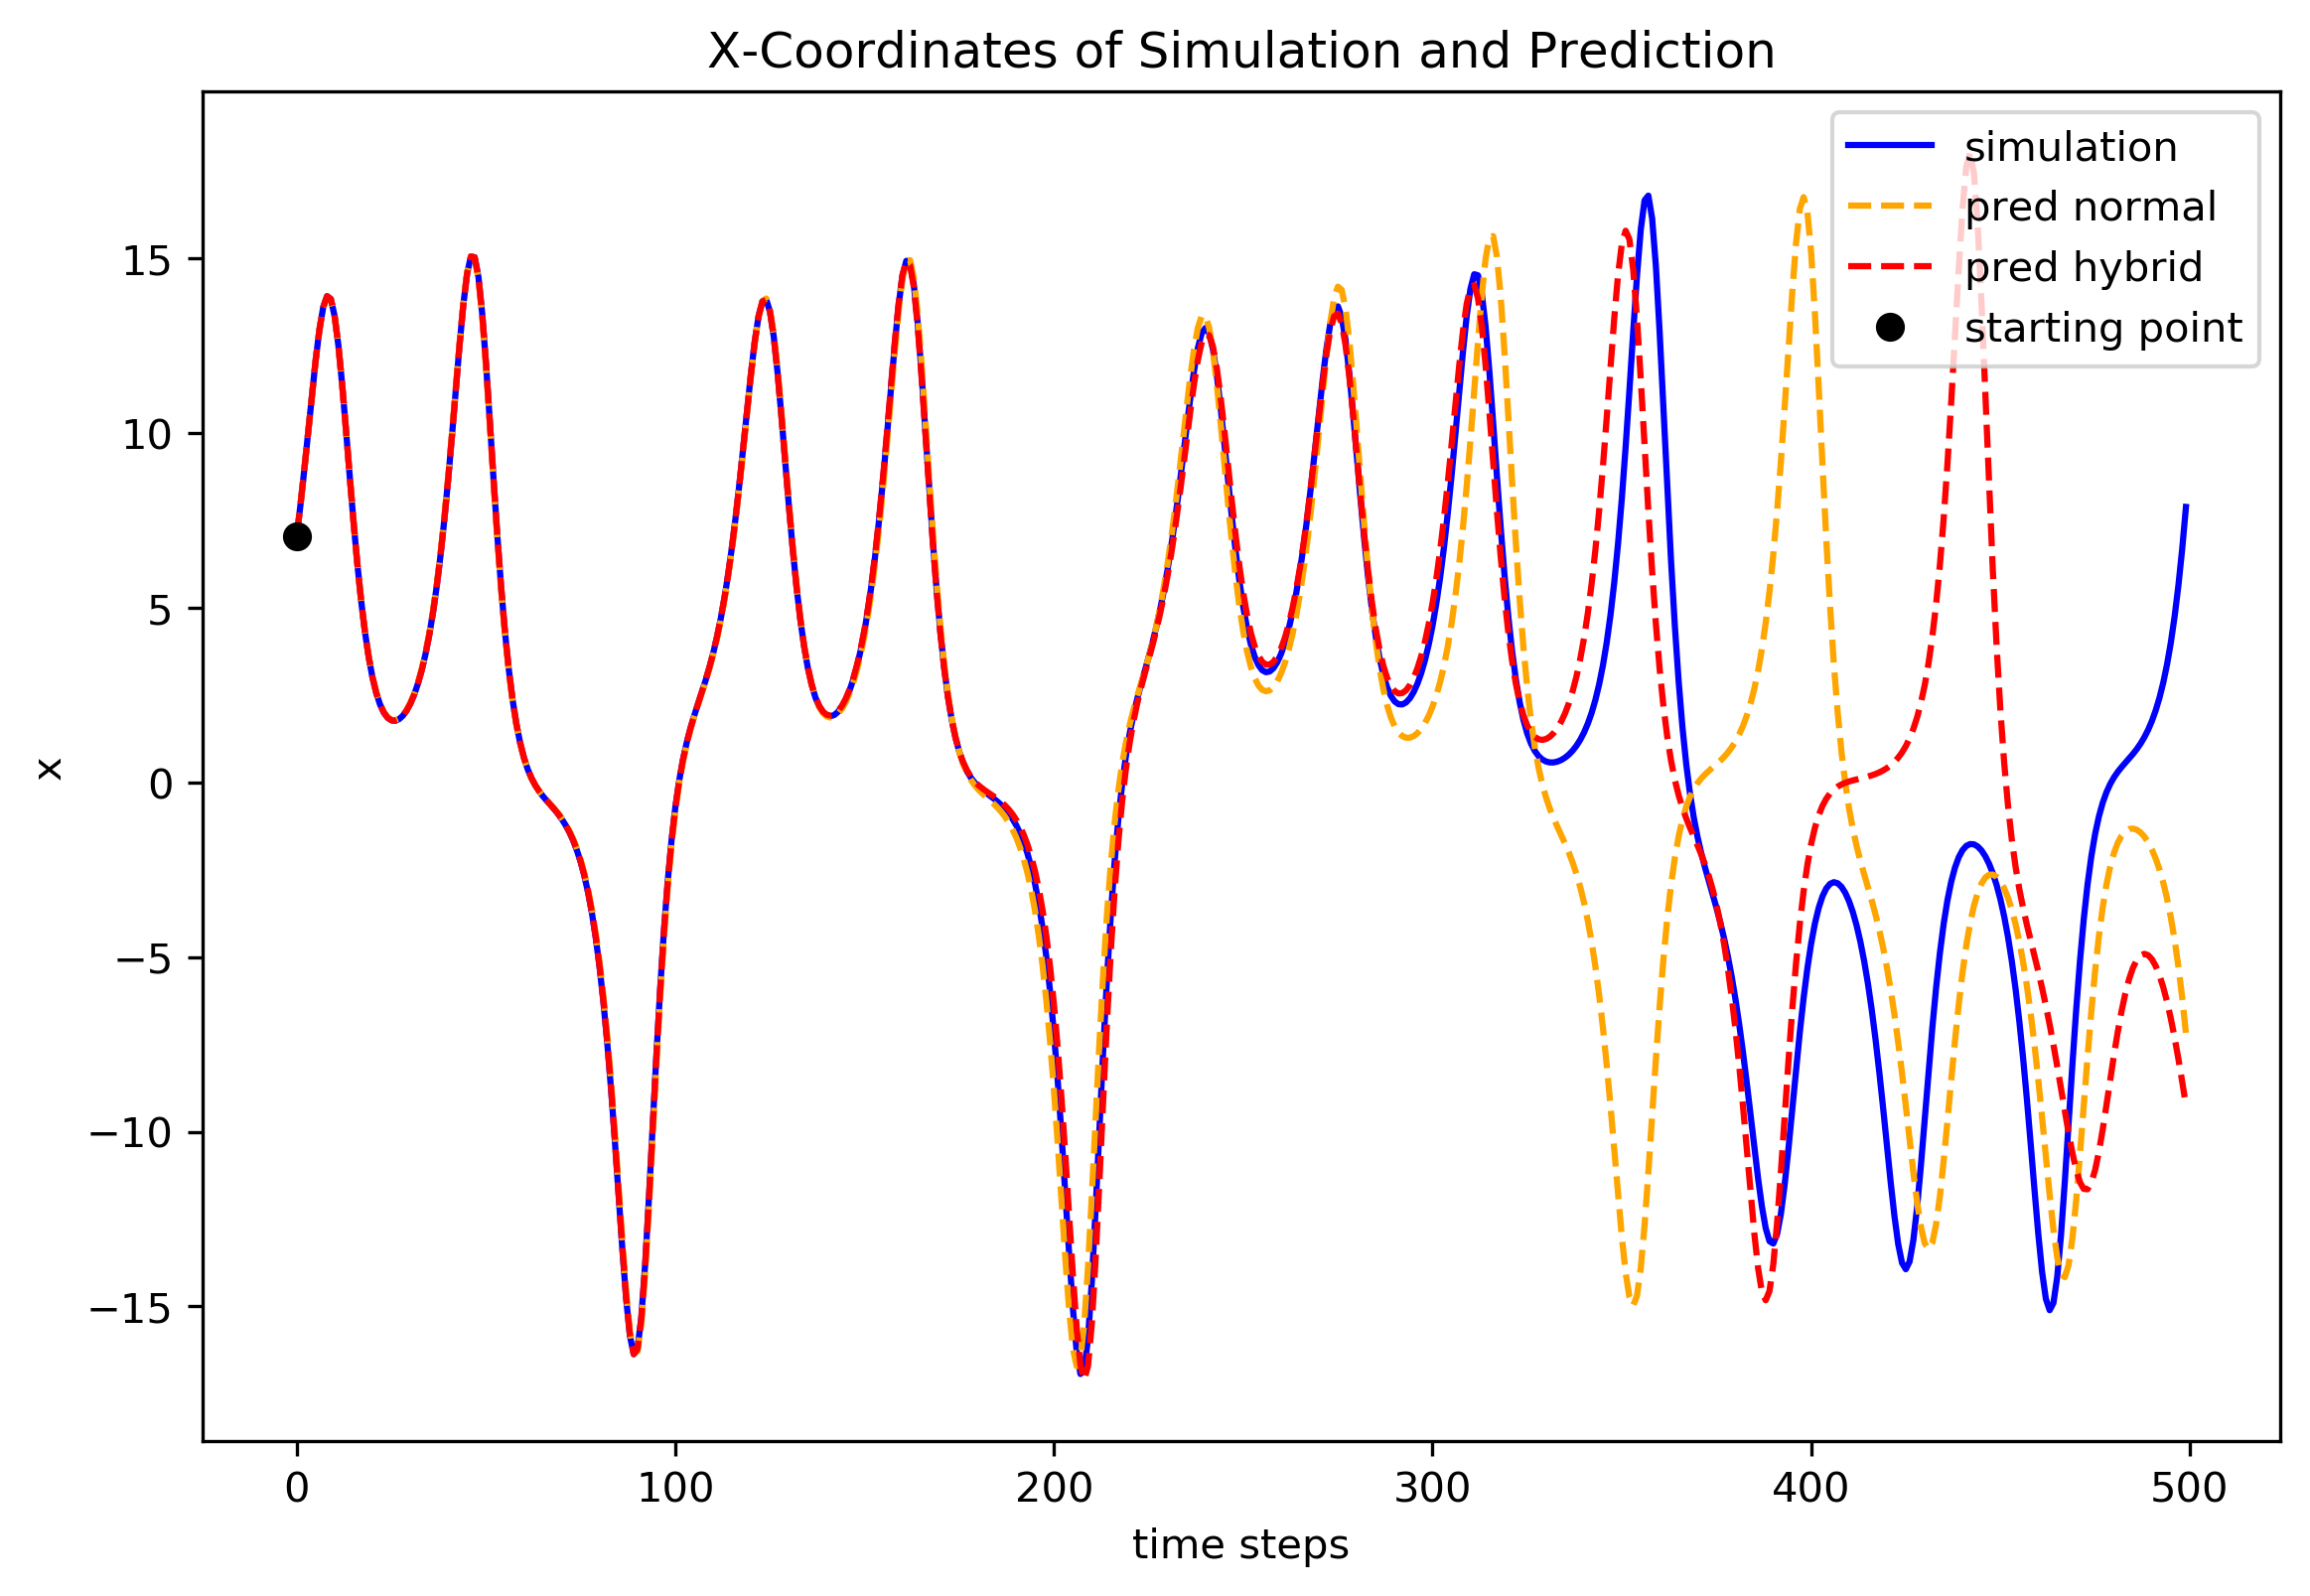

In [43]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test_normal[:, 0], color='blue', label='simulation')
ax2.plot(y_pred_normal[:, 0], color='orange', linestyle='--', label='pred normal')
ax2.plot(y_pred_hybrid[:, 0], color='red', linestyle='--', label='pred hybrid')


start = y_test_normal[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

In [39]:
print(esn_hybrid._w_out.shape)
print(esn_normal._w_out.shape)

print(np.average(esn_hybrid._w_out[:, -3:]))
print(np.average(esn_hybrid._w_out[:, :-3]))

(3, 503)
(3, 500)
0.24856704191135778
0.025878872293089775


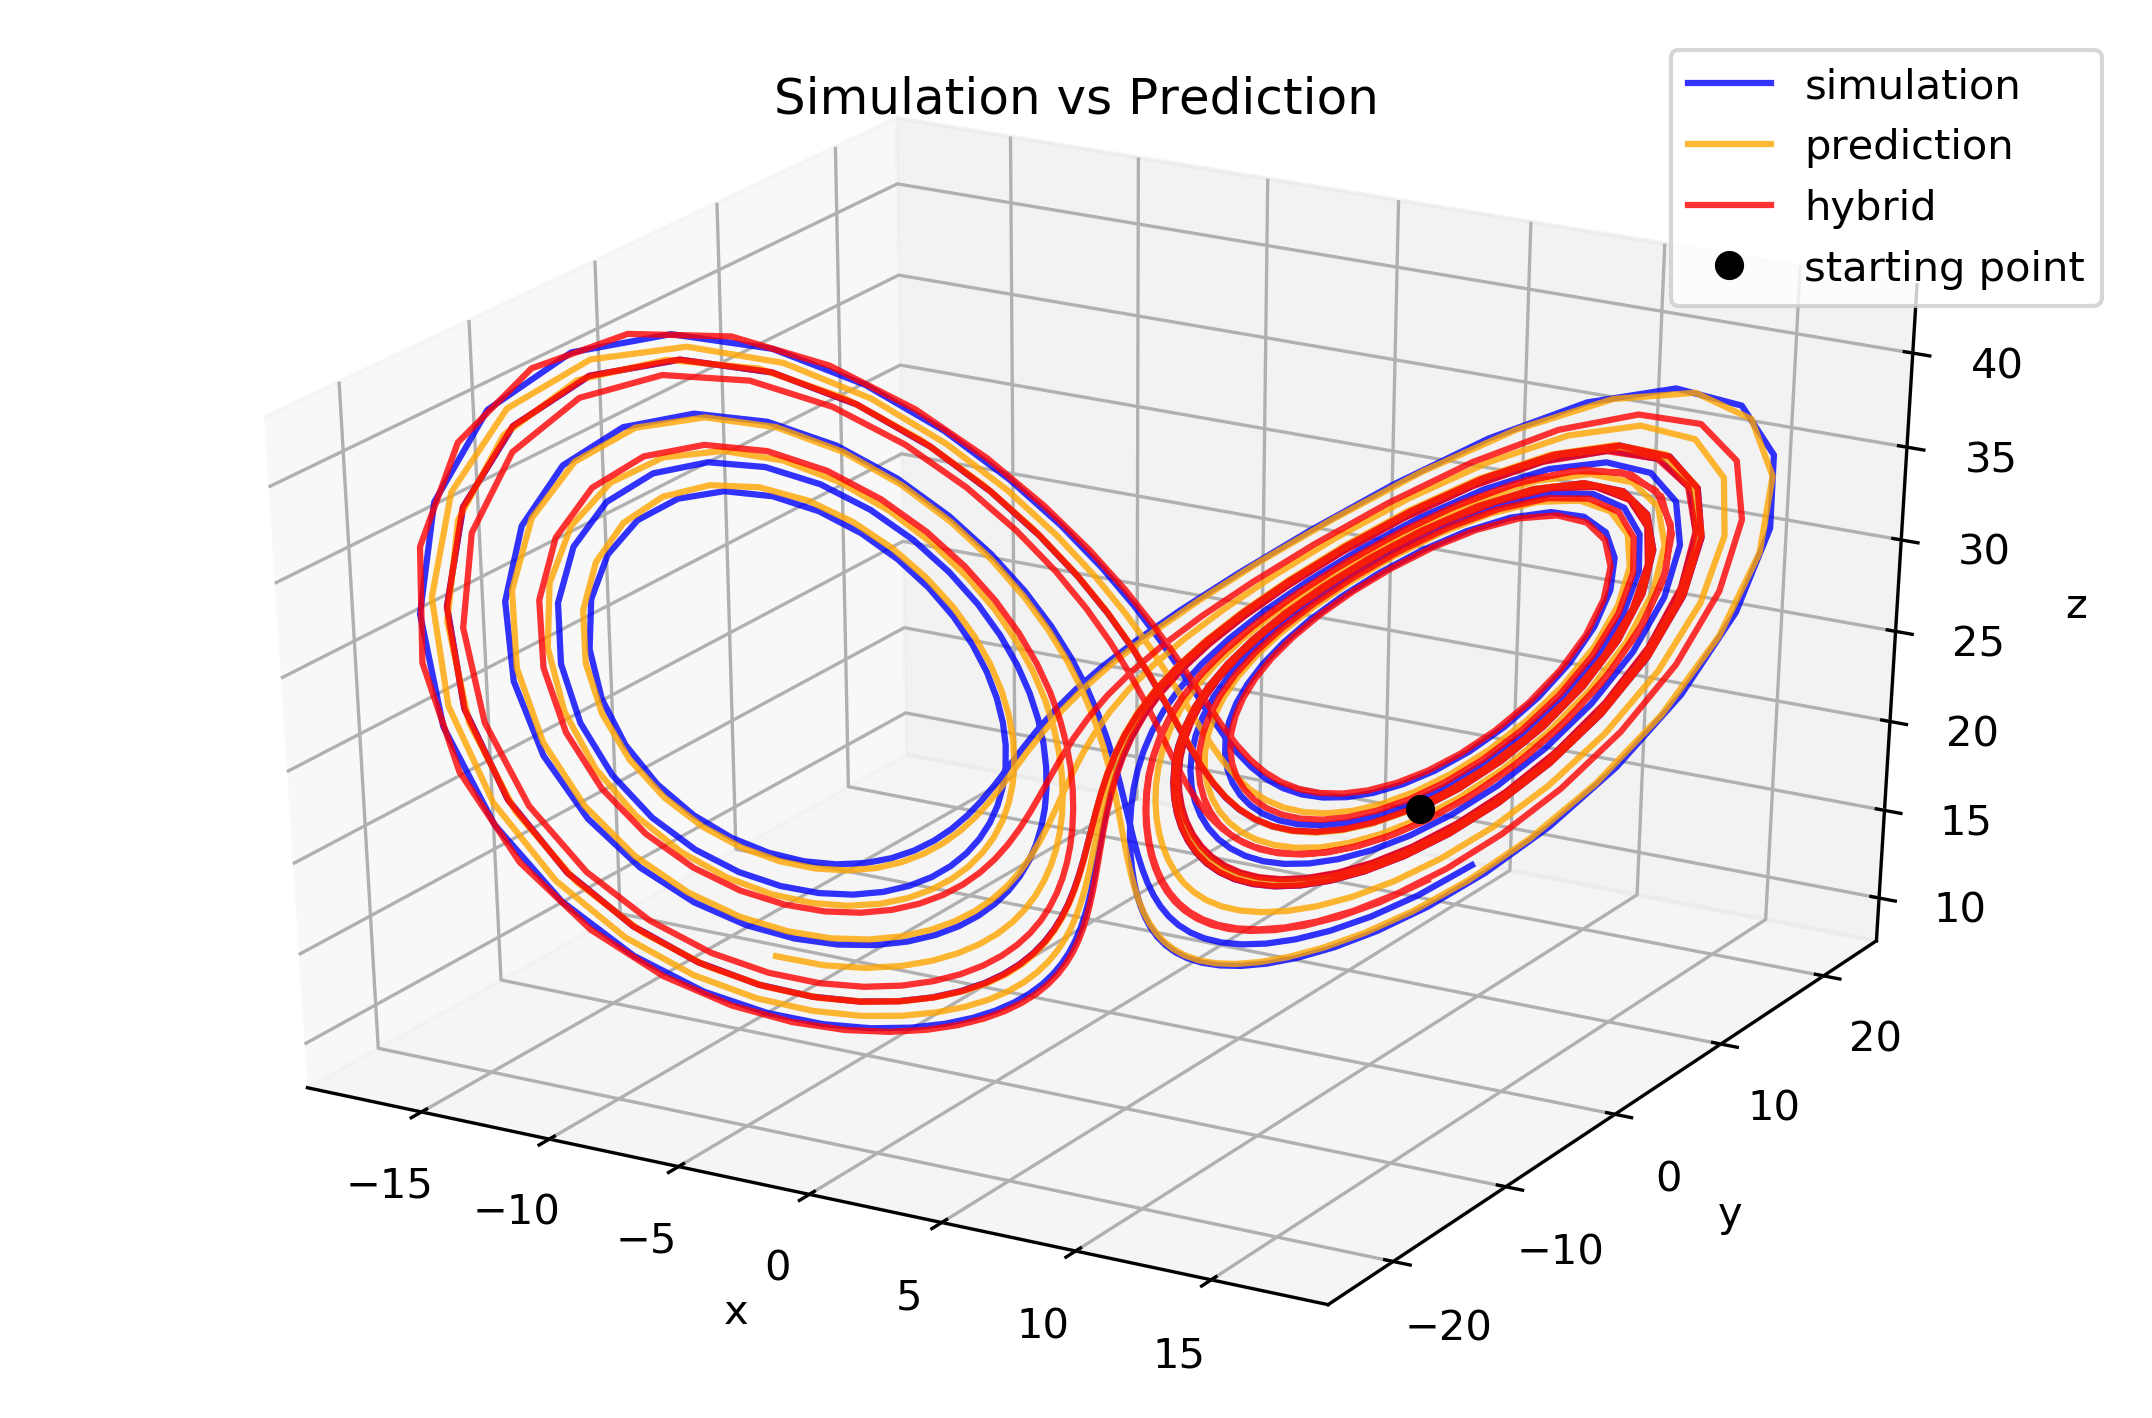

In [26]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot(y_test_normal[:, 0], y_test_normal[:, 1], y_test_normal[:, 2],
        alpha=0.8, color='blue', label='simulation')
ax1.plot(y_pred_normal[:, 0], y_pred_normal[:, 1], y_pred_normal[:, 2],
        alpha=0.8, color='orange', label='prediction')
ax1.plot(y_pred_hybrid[:, 0], y_pred_hybrid[:, 1], y_pred_hybrid[:, 2],
        alpha=0.8, color='red', label='hybrid')

start = y_test_normal[0]
ax1.plot([start[0]], [start[1]], [start[2]], 
         color='black', linestyle='', marker='o', label='starting point')

ax1.set_title("Simulation vs Prediction")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.legend()
plt.show()